In [ ]:
# Pronóstico de Series de Tiempo

# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/Aglaeth/fisica_computacional/main/Actividad4/3042.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251'
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha','Precip','Evap','Tmax','Tmin',]
df_Pocitas = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python') 

# Hacemos una copia de trabajo y preservamos el dataframe original
df_Poc = df_Pocitas.copy()

# Cambiamos la palabra nulo por un vacío y verificamos
str_Nulo = 'Nulo'
df_Paz = df_Poc.replace(to_replace=str_Nulo, value='', regex=True)

# Convertimos los valores de las variables ambientales a números flotantes y verificamos 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_Paz[cols] = pd.to_numeric(df_Poc[cols], errors='coerce')


# Definimos un nuevo dataframe por si hay que regresarse
df_nuv = df_Paz.copy()
df_nuv['Fecha'].head()

# Se convierte el objeto Fecha a variable fecha que python reconoce
df_nuv['Fecha'] = pd.to_datetime(df_nuv['Fecha'], dayfirst=True).copy()

# Añadimos dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.month para extraer el Año y Mes de la Fecha
df_nuv['Año'] = df_nuv['Fecha'].dt.year
df_nuv['Mes'] = df_nuv['Fecha'].dt.month

# Hacemos una copia del trabajo y es con el que trabajaremos para el análisis de datos
df_met = df_nuv.copy()

# Eliminamos la columna de Mes(numérico) y agregamos Mes(caractéres)
df_met.drop('Mes', axis=1, inplace=True)
df_met['Mes'] = df_met['Fecha'].dt.strftime('%b')

# Nueva copia del DataFrame para Series de Tiempo
df_met_ts = df_met.copy()

# Reemplazamos el índice por la variable 'Fecha' 
df_met_ts = df_met.set_index('Fecha')
df_met_ts.info()

# Seleccionaremos un conjunto de años de 30 años
df_80 = df_met_ts[(df_met_ts['Año'] >= 1952) & (df_met_ts['Año'] < 1985)]
df_90 = df_met_ts[(df_met_ts['Año'] >= 1985) & (df_met_ts['Año'] < 2017)]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22961 entries, 1952-09-01 to 2017-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  22950 non-null  float64
 1   Evap    0 non-null      float64
 2   Tmax    22900 non-null  float64
 3   Tmin    22839 non-null  float64
 4   Año     22961 non-null  int64  
 5   Mes     22961 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='darkorange',label='Original')
    plt.plot(rolmean, color='darkgreen', label='Rolling Mean')
    plt.plot(rolstd, color='rebeccapurple', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


1 Estacionaridad 


Este concepto es importante en la teoría de Análisis de Series de Tiempo. Para aplicar un modelo, se requiere determinar si la serie de tiempo es estacionaria, es decir que sus propiedades estadísticas (promedio, varianza, covarianza)  permanezcan constantes en el tiempo. Así podemos prever que las propiedades de la serie de tiempo se van a comportar de la misma forma en el futuro.  

 

In [ ]:
#Empezamos el analisis haciendo una primera serie de tiempo para analizar, la cual corresponde a la epoca de 1975 a 1981

#Fechas de inicio y fin, para filtrar la informacion.
start, end = '1975-11','1981-11'

ts_80=df_80.loc[start:end].copy()
ts_80.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1975-11-01,0.0,NaN,32.0,8.0,1975,Nov
1975-11-02,0.0,NaN,30.0,8.0,1975,Nov
1975-11-03,0.0,NaN,30.0,8.0,1975,Nov
1975-11-04,0.0,NaN,32.0,8.0,1975,Nov
1975-11-05,0.0,NaN,32.0,6.0,1975,Nov


In [ ]:

# Vemos su encabezado
ts_80['Tmax'].head()

Fecha
1975-11-01    32.0
1975-11-02    30.0
1975-11-03    30.0
1975-11-04    32.0
1975-11-05    32.0
Name: Tmax, dtype: float64

In [ ]:

#Definimos la serie de tiempo con la temperatura máxima que vamos a estudiar
#dándola un nombre cualquiera

ts_Prueba_Max =ts_80['Tmax'].copy()

Hacemos el mismo procedimiento pero ahora con la temperatura minima 

In [ ]:
#Creamos la primer serie de Tiempo para analizar, haciendo una copia de la epoca de 1975 a 1981

#Fechas de inicio y fin, para filtrar la informacion.
start, end = '1975-11','1981-11'

ts_80s=df_80.loc[start:end].copy()
ts_80s.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1975-11-01,0.0,NaN,32.0,8.0,1975,Nov
1975-11-02,0.0,NaN,30.0,8.0,1975,Nov
1975-11-03,0.0,NaN,30.0,8.0,1975,Nov
1975-11-04,0.0,NaN,32.0,8.0,1975,Nov
1975-11-05,0.0,NaN,32.0,6.0,1975,Nov


In [ ]:
#Definimos la serie de tiempo con la temperatura máxima que vamos a estudiar
#dándola un nombre cualquiera

ts_Prueba_Min =ts_80['Tmin'].copy()

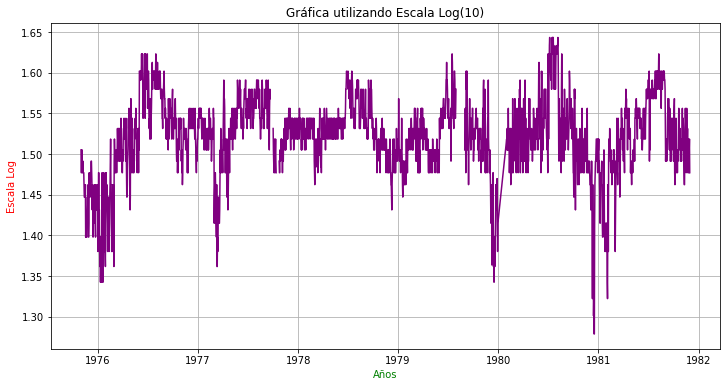

In [ ]:
# Continuamos con la temperatura maxima 

# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_Prueba_log = np.log10(ts_Prueba_Max)
plt.plot(ts_Prueba_log, color='purple')
plt.xlabel('Años',color='g')
plt.ylabel('Escala Log',color='r')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

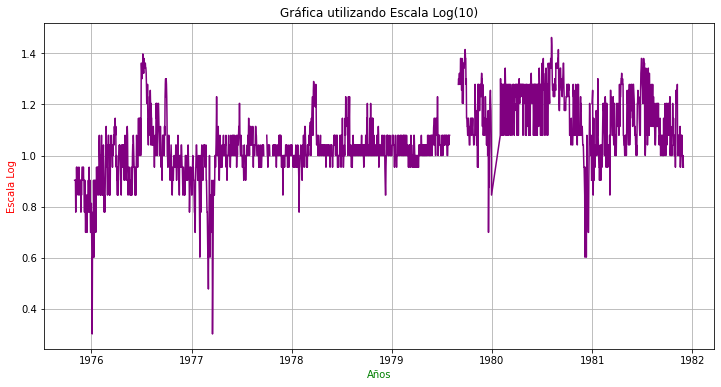

In [ ]:
# Repetimos el mismo procedimiento pero ahora para la temperatura minima 

# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_PruebaMin_log = np.log10(ts_Prueba_Min)
plt.plot(ts_PruebaMin_log, color='purple')
plt.xlabel('Años',color='g')
plt.ylabel('Escala Log',color='r')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

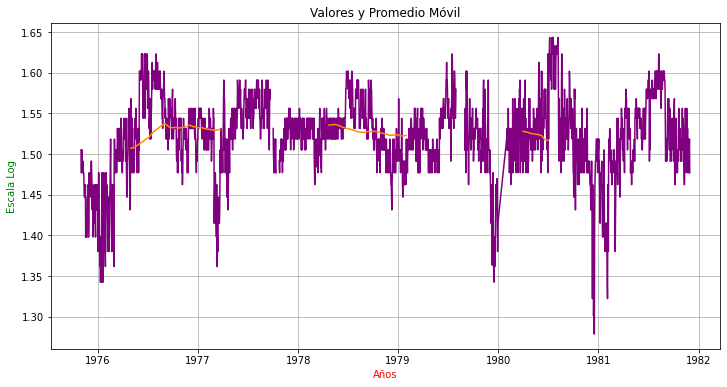

In [ ]:
moving_avg = ts_Prueba_log.rolling(365, center=True).mean()
plt.plot(ts_Prueba_log, color='purple')
plt.plot(moving_avg, color = 'darkorange')
plt.xlabel('Años',color='r')
plt.ylabel('Escala Log',color='g')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:
ts_Prueba_log_moving_ave_diff = ts_Prueba_log - moving_avg 
ts_Prueba_log_moving_ave_diff.head()

Fecha
1975-11-01   NaN
1975-11-02   NaN
1975-11-03   NaN
1975-11-04   NaN
1975-11-05   NaN
Name: Tmax, dtype: float64

In [ ]:
ts_Prueba_log_moving_ave_diff.dropna(inplace=True)
ts_Prueba_log_moving_ave_diff.head()

Fecha
1976-05-01    0.060796
1976-05-02    0.024001
1976-05-03   -0.016155
1976-05-04   -0.030472
1976-05-05    0.023962
Name: Tmax, dtype: float64

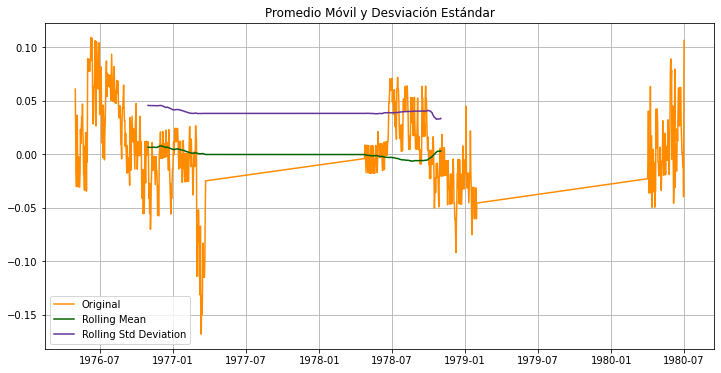

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -4.268516
p-value                          0.000503
#Lags Used                       4.000000
Number of Observations Used    696.000000
Critical Value (1%)             -3.439780
Critical Value (5%)             -2.865702
Critical Value (10%)            -2.568986
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_Prueba_log_moving_ave_diff)

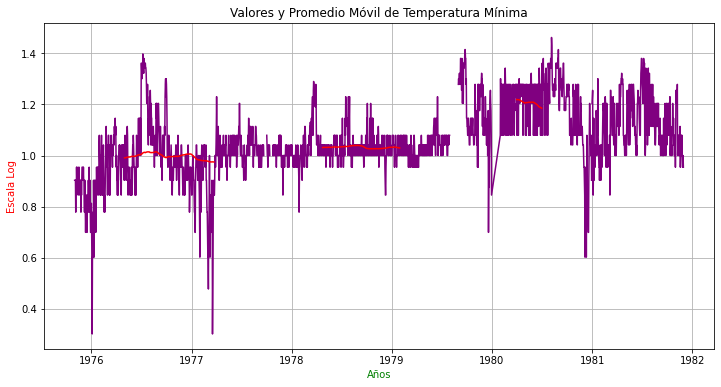

In [ ]:
moving_avg = ts_PruebaMin_log.rolling(365, center=True).mean()
plt.plot(ts_PruebaMin_log, color='purple')
plt.plot(moving_avg, color = 'r')
plt.xlabel('Años',color='g')
plt.ylabel('Escala Log',color='r')
plt.title('Valores y Promedio Móvil de Temperatura Mínima')
plt.grid()
plt.show();

In [ ]:
ts_PruebaMin_log_moving_ave_diff = ts_PruebaMin_log - moving_avg 
ts_PruebaMin_log_moving_ave_diff.head()

Fecha
1975-11-01   NaN
1975-11-02   NaN
1975-11-03   NaN
1975-11-04   NaN
1975-11-05   NaN
Name: Tmin, dtype: float64

In [ ]:

ts_PruebaMin_log_moving_ave_diff.dropna(inplace=True)
ts_PruebaMin_log_moving_ave_diff.head()

Fecha
1976-05-01    0.050616
1976-05-02    0.009083
1976-05-03    0.088124
1976-05-04    0.050070
1976-05-05   -0.037220
Name: Tmin, dtype: float64

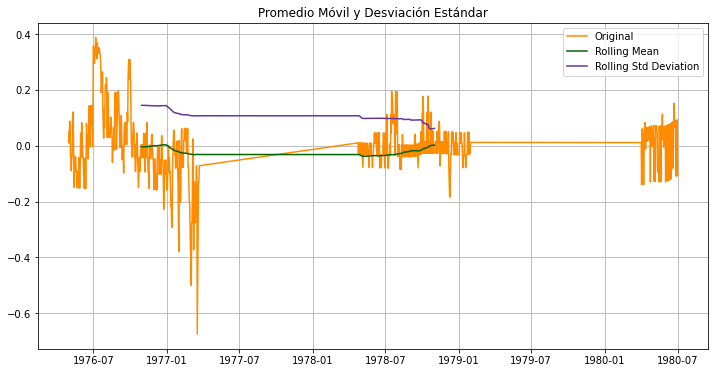

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -5.191470
p-value                          0.000009
#Lags Used                       4.000000
Number of Observations Used    696.000000
Critical Value (1%)             -3.439780
Critical Value (5%)             -2.865702
Critical Value (10%)            -2.568986
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_PruebaMin_log_moving_ave_diff)

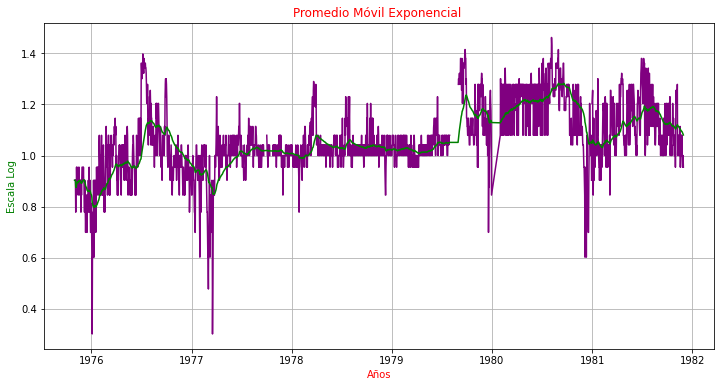

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 


EWM_avg = ts_PruebaMin_log.ewm(halflife=30).mean()
plt.plot(ts_PruebaMin_log, color='purple')
plt.plot(EWM_avg, color = 'g')
plt.xlabel('Años',color='r')
plt.ylabel('Escala Log',color='g')
plt.title('Promedio Móvil Exponencial ', color = 'r'  )
plt.grid()
plt.show();

In [ ]:
EWM_avg.head()

Fecha
1975-11-01    0.903090
1975-11-02    0.903090
1975-11-03    0.903090
1975-11-04    0.903090
1975-11-05    0.876934
Name: Tmin, dtype: float64

In [ ]:
# Probamos la estacionarida de la diferencia 
ts_PruebaMin_log_EWM_avg = ts_PruebaMin_log - EWM_avg

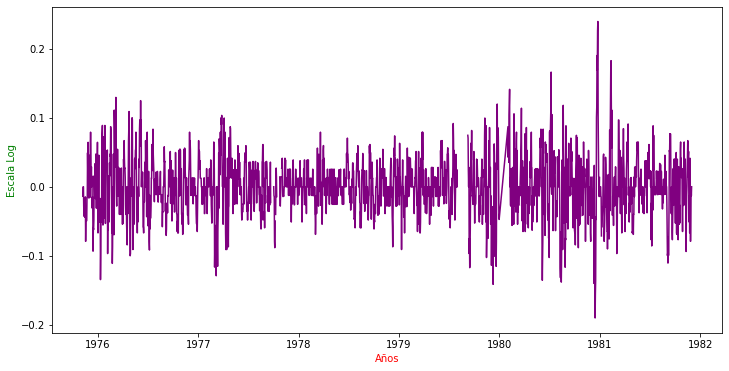

In [ ]:
# Para la temperatura maxima 
# Diferenciamos usando la función df.shift()
ts_Prueba_log_diff = ts_Prueba_log - ts_Prueba_log.shift(periods=7)
plt.xlabel('Años',color='r')
plt.ylabel('Escala Log',color='g')
plt.plot(ts_Prueba_log_diff, color='purple');

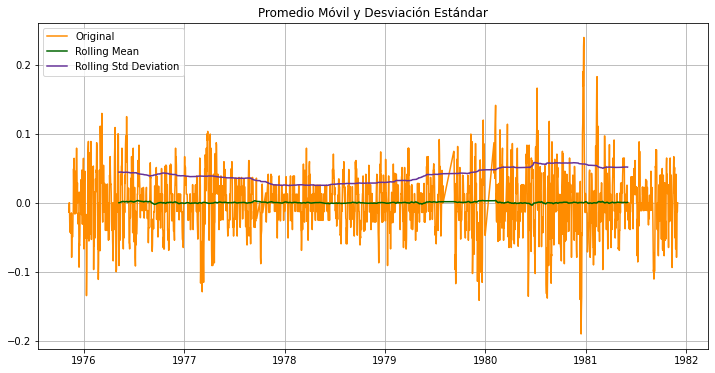

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.097139e+01
p-value                        7.864259e-20
#Lags Used                     2.600000e+01
Number of Observations Used    2.095000e+03
Critical Value (1%)           -3.433475e+00
Critical Value (5%)           -2.862921e+00
Critical Value (10%)          -2.567505e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_Prueba_log_diff.dropna(inplace=True)
test_stationarity(ts_Prueba_log_diff)

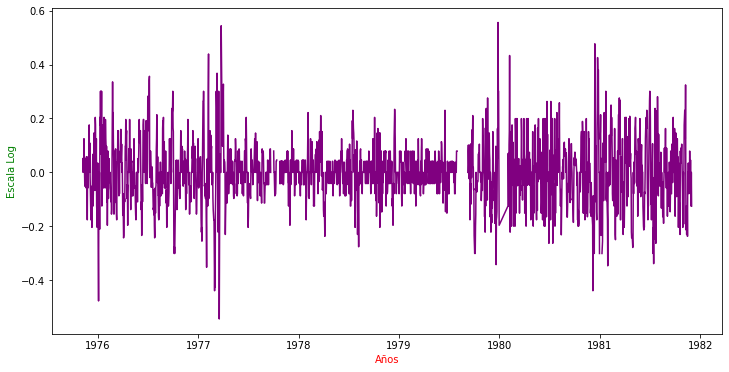

In [ ]:
# Repetimos el mismo procedimiento pero ahora para la temperatura minima 

# Diferenciamos usando la función df.shift()
ts_PruebaMin_log_diff = ts_PruebaMin_log - ts_PruebaMin_log.shift(periods=7)
plt.xlabel('Años',color='r')
plt.ylabel('Escala Log',color='g')
plt.plot(ts_PruebaMin_log_diff, color='purple');

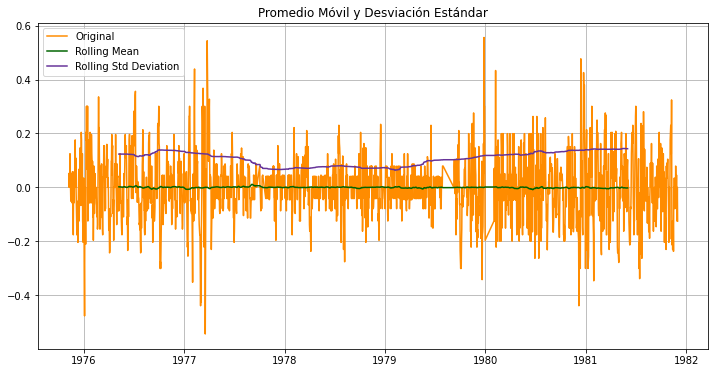

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.129934e+01
p-value                        1.319318e-20
#Lags Used                     2.400000e+01
Number of Observations Used    2.097000e+03
Critical Value (1%)           -3.433472e+00
Critical Value (5%)           -2.862919e+00
Critical Value (10%)          -2.567504e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_PruebaMin_log_diff.dropna(inplace=True)
test_stationarity(ts_PruebaMin_log_diff)

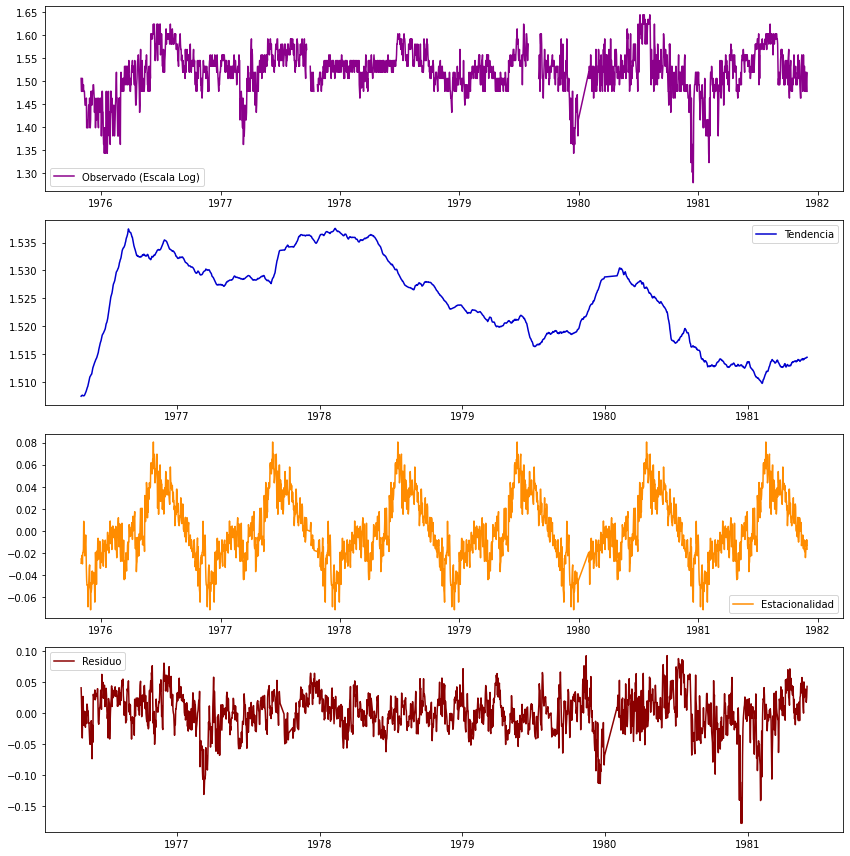

In [ ]:
# Para la temperatura maxima 


# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_Prueba_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_Prueba_log, label='Observado (Escala Log)', color='darkmagenta')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='mediumblue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='darkorange')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo', color='darkred')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

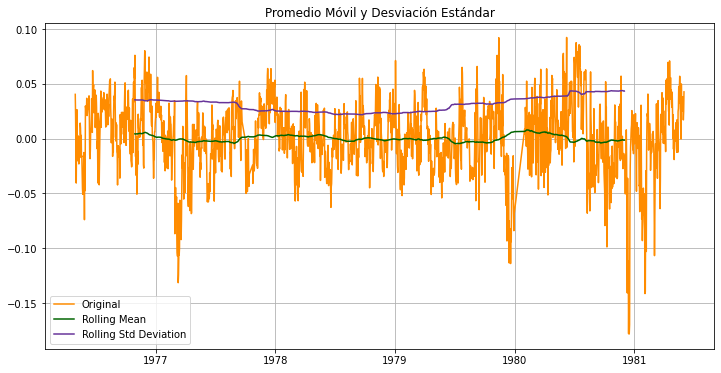

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.015994e+00
p-value                        2.138213e-12
#Lags Used                     7.000000e+00
Number of Observations Used    1.801000e+03
Critical Value (1%)           -3.433986e+00
Critical Value (5%)           -2.863146e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


In [ ]:

# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_Prueba_log_decompose = residue 
ts_Prueba_log_decompose.dropna(inplace=True)
test_stationarity(ts_Prueba_log_decompose)

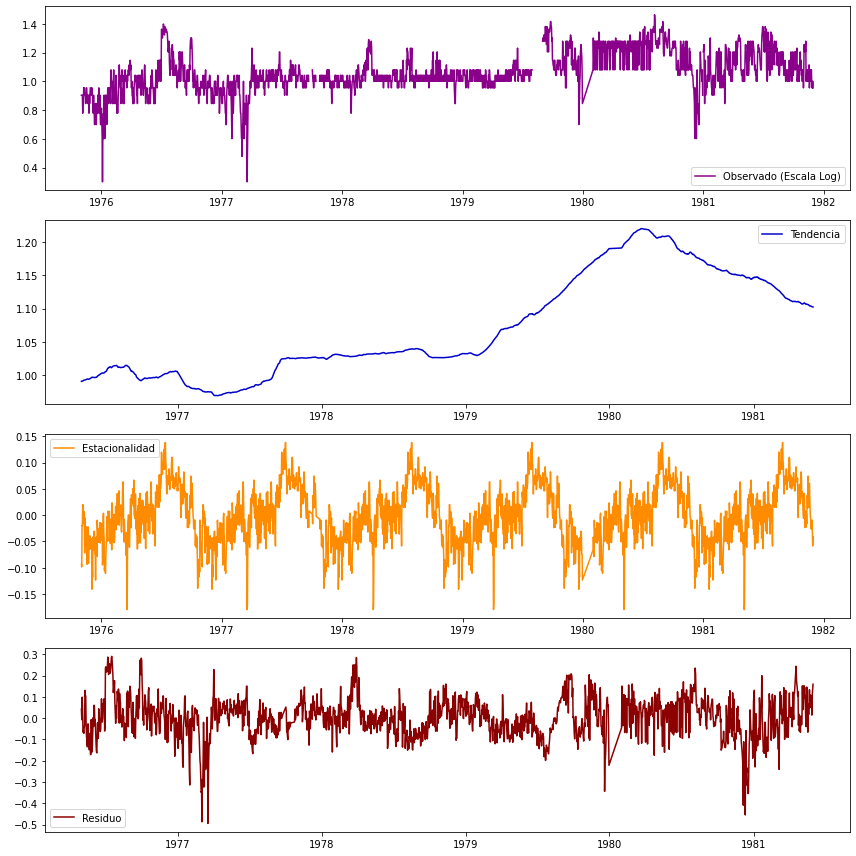

In [ ]:
# Repetimos el mismo procedimiento pero ahora para la temperatura minima 

# Método de descomposición usando la biblioteca statsmodels.tsa

decompositionMin = sm.tsa.seasonal_decompose(ts_PruebaMin_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decompositionMin.trend
seasonal = decompositionMin.seasonal
residue = decompositionMin.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_PruebaMin_log, label='Observado (Escala Log)', color='darkmagenta')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='mediumblue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='darkorange')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo', color='darkred')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

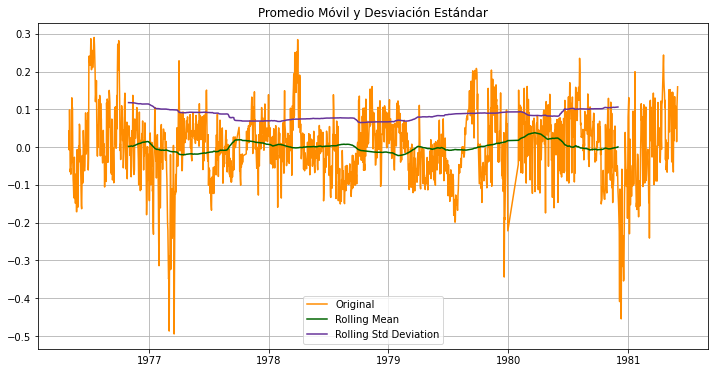

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.167957e+00
p-value                        2.853576e-10
#Lags Used                     7.000000e+00
Number of Observations Used    1.801000e+03
Critical Value (1%)           -3.433986e+00
Critical Value (5%)           -2.863146e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


In [ ]:

# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_PruebaMin_log_decompose = residue 
ts_PruebaMin_log_decompose.dropna(inplace=True)
test_stationarity(ts_PruebaMin_log_decompose)

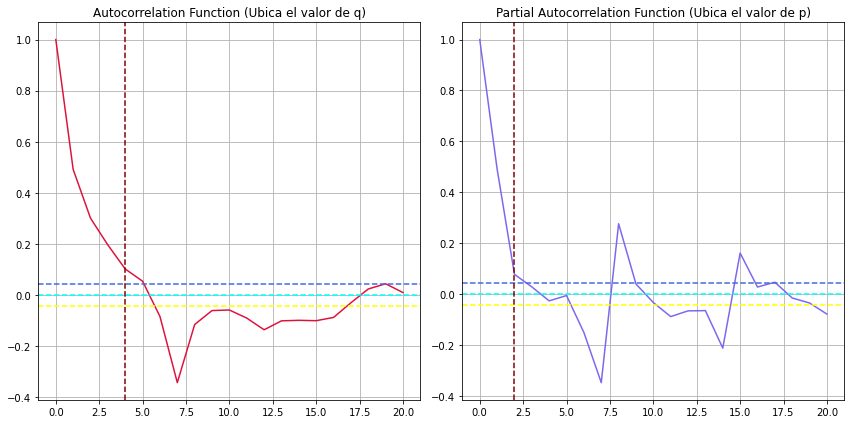

In [ ]:
# Para la temperatura minima
# Aplicamos ARIMA

lag_acf = acf(ts_PruebaMin_log_diff, nlags=20)
lag_pacf = pacf(ts_PruebaMin_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf, color='crimson')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='maroon')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf, color='mediumslateblue')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='maroon')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2138
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4750.382
Method:                       css-mle   S.D. of innovations              0.026
Date:                Sun, 14 Mar 2021   AIC                          -9492.763
Time:                        06:13:41   BIC                          -9470.093
Sample:                             1   HQIC                         -9484.467
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.155e-06      0.000     -0.008      0.993      -0.001       0.001
ar.L1.D.Tmax    -0.3250      0.021    -15.224      0.000      -0.367      -0.283
ar.L2.D.Tmax    -0.1625      0.021     -7.61

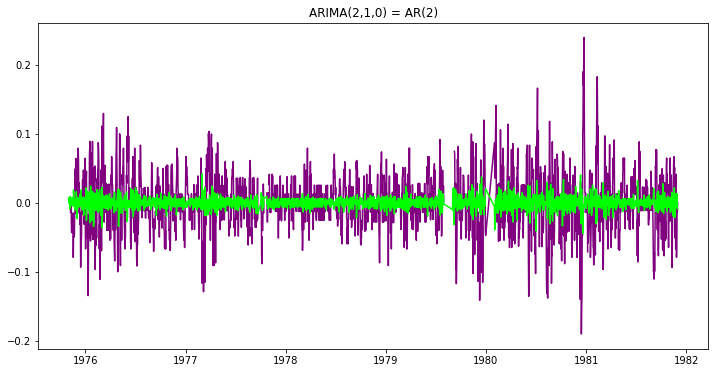

In [ ]:
# Temperatura maxima 

# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_Prueba_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_Prueba_log_diff, color='purple')
plt.plot(results_AR.fittedvalues, color='lime')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2138
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2504.513
Method:                       css-mle   S.D. of innovations              0.075
Date:                Sun, 14 Mar 2021   AIC                          -5001.027
Time:                        06:16:52   BIC                          -4978.356
Sample:                             1   HQIC                         -4992.731
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.911e-05      0.001      0.028      0.978      -0.002       0.002
ar.L1.D.Tmin    -0.3781      0.021    -17.795      0.000      -0.420      -0.336
ar.L2.D.Tmin    -0.1852      0.021     -8.71

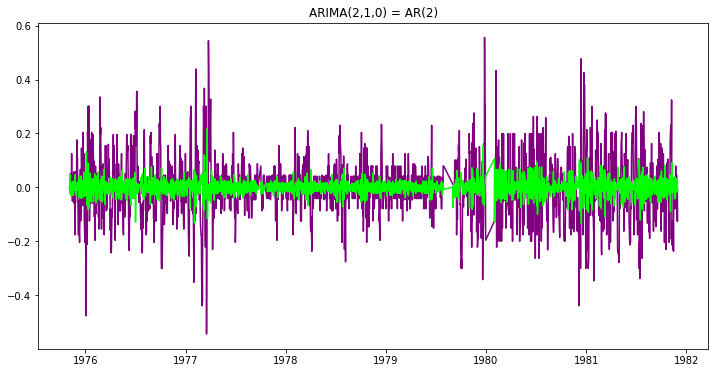

In [ ]:
# Mismo procedimiento con la temperatura minima 
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_PruebaMin_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_PruebaMin_log_diff, color='purple')
plt.plot(results_AR.fittedvalues, color='lime')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2138
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4816.454
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sun, 14 Mar 2021   AIC                          -9620.908
Time:                        06:25:56   BIC                          -9586.902
Sample:                             1   HQIC                         -9608.463
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.347e-06      0.000      0.033      0.974      -0.000       0.000
ma.L1.D.Tmax    -0.3965      0.022    -18.367      0.000      -0.439      -0.354
ma.L2.D.Tmax    -0.1282      0.023     -5.55

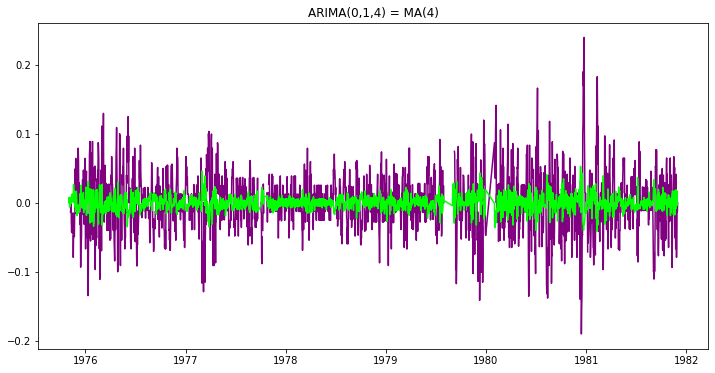

In [ ]:
# Para la temperatura maxima 


# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_Prueba_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_Prueba_log_diff,color='purple' )
plt.plot(results_MA.fittedvalues, color='lime')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2138
Model:                 ARIMA(2, 1, 4)   Log Likelihood                2582.496
Method:                       css-mle   S.D. of innovations              0.072
Date:                Sun, 14 Mar 2021   AIC                          -5148.991
Time:                        06:29:11   BIC                          -5103.650
Sample:                             1   HQIC                         -5132.399
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.125e-05      0.000      0.392      0.695      -0.000       0.000
ar.L1.D.Tmin    -0.0343      0.126     -0.272      0.785      -0.282       0.213
ar.L2.D.Tmin     0.8024      0.116      6.94

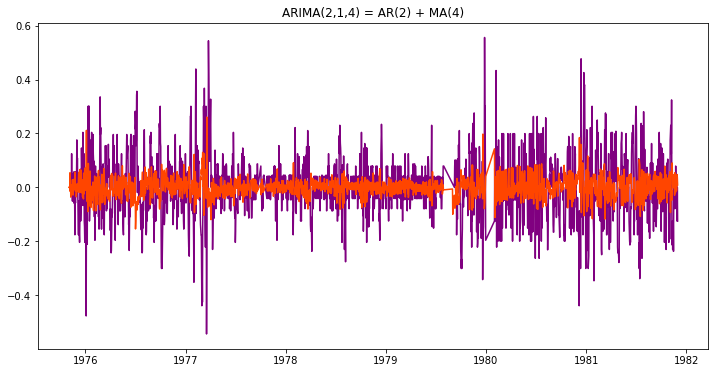

In [ ]:
# Mismo procedimiento pero para la temperatura minima 
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_PruebaMin_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_PruebaMin_log_diff, color='purple')
plt.plot(results_ARIMA.fittedvalues, color='orangered')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1975-11-02    0.000081
1975-11-03    0.000107
1975-11-04    0.000131
1975-11-05    0.000149
1975-11-06    0.054170
                ...   
1981-11-26   -0.011851
1981-11-27    0.028377
1981-11-28    0.047716
1981-11-29    0.036387
1981-11-30    0.008822
Length: 2138, dtype: float64


In [ ]:

# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_Prueba_log, index = ts_Prueba_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1975-11-01         NaN
1975-11-02    1.477203
1975-11-03    1.477228
1975-11-04    1.505281
1975-11-05    1.505299
dtype: float64
Fecha
1981-11-26    1.465270
1981-11-27    1.505498
1981-11-28    1.552866
1981-11-29    1.554901
1981-11-30    1.485943
dtype: float64


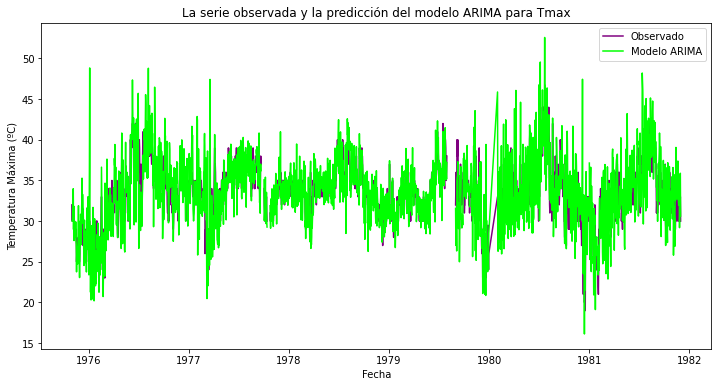

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_Prueba_Max, label='Observado', color='purple');
plt.plot(predictions_ARIMA, label='Modelo ARIMA', color='lime');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_Prueba_Max)**2))
print('RMSE:', RMSE)

RMSE: 2.785394731319126


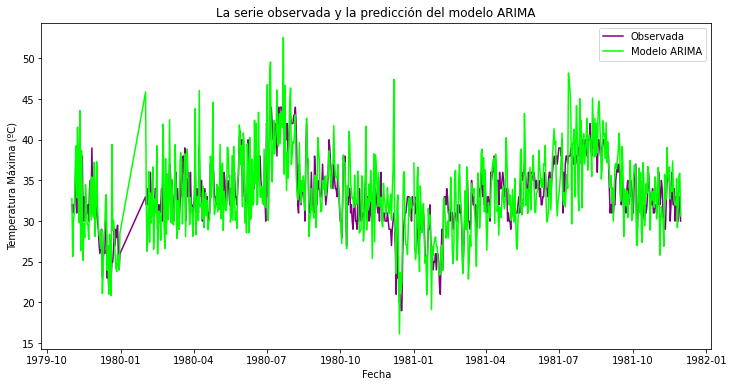

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_Prueba_last = ts_Prueba_Max.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_Prueba_last, label='Observada', color='purple');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA', color='lime');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

In [ ]:
# Procedimiento para la temperatura minima 
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1975-11-02    0.000081
1975-11-03    0.000107
1975-11-04    0.000131
1975-11-05    0.000149
1975-11-06    0.054170
                ...   
1981-11-26   -0.011851
1981-11-27    0.028377
1981-11-28    0.047716
1981-11-29    0.036387
1981-11-30    0.008822
Length: 2138, dtype: float64


In [ ]:

# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_PruebaMin_log, index = ts_PruebaMin_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1975-11-01         NaN
1975-11-02    0.903171
1975-11-03    0.903197
1975-11-04    0.903221
1975-11-05    0.778300
dtype: float64
Fecha
1981-11-26    0.988149
1981-11-27    0.982620
1981-11-28    1.001959
1981-11-29    1.036387
1981-11-30    0.963064
dtype: float64


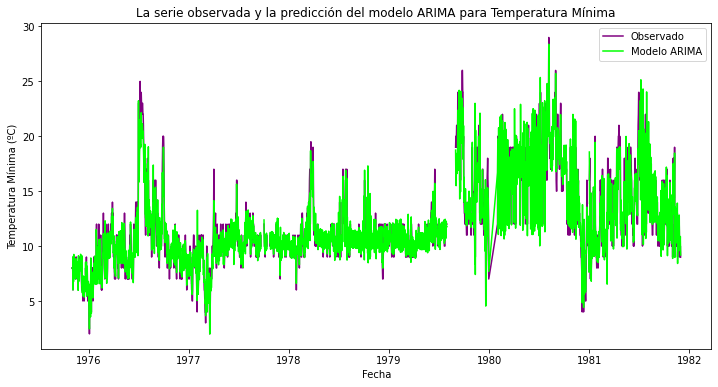

In [ ]:

# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_Prueba_Min, label='Observado', color='purple');
plt.plot(predictions_ARIMA, label='Modelo ARIMA', color='lime');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Mínima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Temperatura Mínima')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_Prueba_Min)**2))
print('RMSE:', RMSE)

RMSE: 1.099693369219649


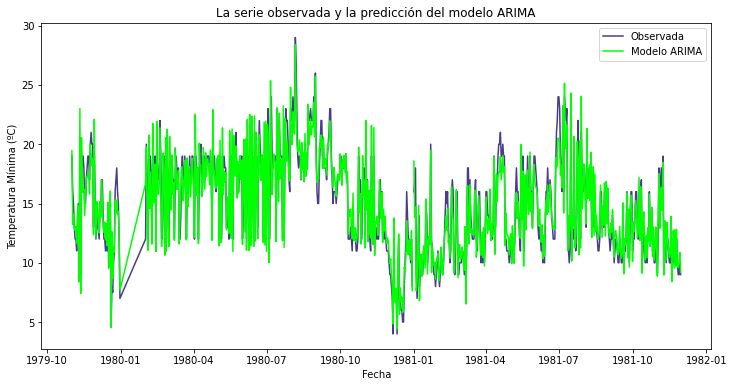

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_PruebaMin_last = ts_Prueba_Min.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_PruebaMin_last, label='Observada', color='darkslateblue');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA', color='lime');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Mínima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');